In [28]:
import pandas as pd
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# data_dir = os.getcwd() + "/Dataset/Images/"
# dest_dir = os.getcwd() + "/Dataset/individual/"

In [3]:
! ls

Dataset
HAM10000_metadata
HAM10000_segmentations_lesion_tschandl.zip
ISIC2018_Task3_Test_Images.zip
ISIC2018_Task3_Test_NatureMedicine_AI_Interaction_Benefit.csv
Image_loader.ipynb


In [4]:
# df = pd.read_csv('HAM10000_metadata')

In [5]:
# classes = df['dx'].unique().tolist()  #Extract labels into a list
# class_id = []

In [6]:
# for i in classes:
#     os.mkdir(dest_dir + str(i) + "/")
#     sample = df[df['dx'] == i]['image_id']
#     class_id.extend(sample)
#     for id in class_id:
#         shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
#     class_id = []

In [7]:
train_dir = ('Dataset/individual')
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed = 456,
    shuffle = True,
    image_size = (256,256),
    batch_size = 32
)

Found 10015 files belonging to 7 classes.


In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 5 5 5 5 4 5 5 4 5 4 4 5 5 1 5 5 5 6 5 1 0 2 5 5 1 5 5 5 2 4 1]


In [9]:
classes = dataset.class_names
classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

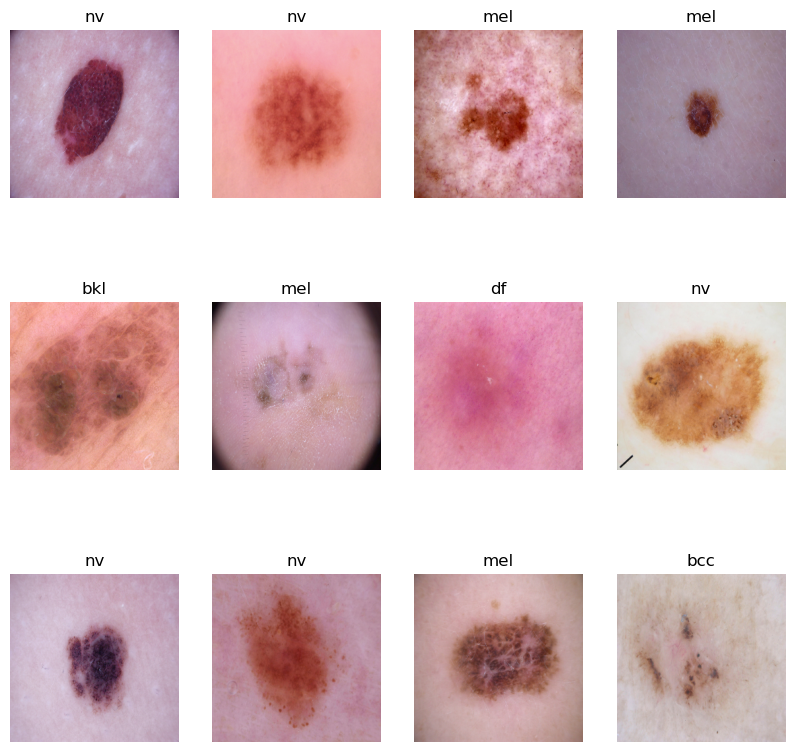

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[labels_batch[i]])
        plt.axis("off")

In [11]:
print('Value counts of classes')
for dx in classes:
    dir_path = f'Dataset/individual/{dx}'
    count = 0
    for path in os.listdir(dir_path):
        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    print(f'{dx}:', count)

Value counts of classes
akiec: 327
bcc: 514
bkl: 1099
df: 115
mel: 1113
nv: 6705
vasc: 142


In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

250

In [15]:
class_weights_manual = {0: 4.424889543446245,
 1: 2.833097595473833,
 2: 1.339202139514152,
 3: 14.072599531615925,
 4: 1.3026230218946455,
 5: 0.21180078248916145,
 6: 8.759475218658892}

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [30]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        'Dataset/individual',
        target_size=(256,256),
        batch_size=32,
        class_mode="sparse")

Found 10015 images belonging to 7 classes.


In [17]:
input_shape = (32, 256,256, 3)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [18]:
model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
model.fit_generator(
        train_generator,
        validation_data=val_ds,
        verbose=1,
        epochs=2,
        class_weight=class_weights_manual)

C:\Users\beelk\AppData\Local\Temp\ipykernel_30932\4167777972.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/2
313/313 [==============================] - 472s 2s/step - loss: 1.9640 - accuracy: 0.0131 - val_loss: 1.9409 - val_accuracy: 0.0151
Epoch 2/2
313/313 [==============================] - 457s 1s/step - loss: 1.9627 - accuracy: 0.0115 - val_loss: 1.9533 - val_accuracy: 0.0101
